In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import collections

# import sparseqr

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
# import solve_laplace_operator

# def check_convergence(L, tolerance=0.001):
#     N = len(L)
#     if N < 3:
#         return False

#     # Calculate the mean and standard deviation
#     sample_mean = np.mean(L)
#     sample_std = np.std(L, ddof=1)

#     # Calculate the confidence interval width
#     z = 1.96  # For approximately 95% confidence
#     ci_half_width = z * (sample_std / np.sqrt(N))

#     # Check if the mean is stable
#     if N > 2:
#         prev_mean = np.mean(L[:-1])
#         mean_change = abs((sample_mean - prev_mean) / prev_mean)
#         if mean_change > tolerance:
#             return False

#     # Check if confidence interval is narrow enough
#     relative_ci_width = 2 * ci_half_width / sample_mean
#     if relative_ci_width > tolerance:
#         return False

#     return True

%load_ext autoreload
%autoreload 2

In [300]:
def check_convergence(L, base_tolerance=0.01, min_tolerance=1e-8, mean_previous_graph_size=None):

    if len(L) < 3:
        return False
    
    mean_previous_sampling = np.mean(L[:-1])
    current_mean = np.mean(L)
    dif_mean_previous_sampling = np.abs((current_mean - mean_previous_sampling) / mean_previous_sampling)

    if mean_previous_graph_size == None:
        adaptive_tolerance = 0.001
        
    else:
        dif_mean_previous_graph_size = np.abs((current_mean - mean_previous_graph_size) / mean_previous_graph_size)
        adaptive_tolerance = np.max((dif_mean_previous_graph_size * base_tolerance, min_tolerance))

    print(f"\nCurrent dif = {dif_mean_previous_sampling} vs. adaptive tol = {adaptive_tolerance}\n")

    if dif_mean_previous_sampling > adaptive_tolerance:
        return False
    else:
        return True

def sequential_Newton(guesses, eigs):
    """Search for closeish convergence. Then search for full convergence. 
    Then clean solutions (get rid of neg, too large, nans)"""
    solutions = []
    for guess in guesses:
        solution = eigs(guess, solve_type="SVD iterate", printerval=np.inf, tol=1e-4, max_steps=20)
        solutions.append(solution)
        _, index = np.unique(np.round(solutions, 3), return_index=True)
        solutions = list(np.array(solutions)[index])
    full_solutions = eigs(solutions, solve_type="SVD iterate", printerval=10, tol=1e-13, max_steps=20)
    _, inds = np.unique(np.round(full_solutions, 8), return_index=True)

    full_solutions = full_solutions[inds]
    mask_too_small = full_solutions < 2
    mask_too_big = full_solutions > 5
    mask_isnan = np.isnan(full_solutions)
    mask_good = ~ (mask_too_small | mask_too_big | mask_isnan)
    full_solutions = full_solutions[mask_good]

    return full_solutions

In [414]:
nums_Vs = (10**np.linspace(3, 5, 11)).astype(int)[:8]
print(nums_Vs)

[ 1000  1584  2511  3981  6309 10000 15848 25118]


In [415]:
for en, num_Vs in enumerate(nums_Vs):
    print(f"\n\ngraph size = {en + 1} / {len(nums_Vs)}\n\n\n")

    if num_Vs < 900:
        guesses = np.linspace(3.5, 4.5, 40)
    elif num_Vs < 2000:
        guesses = np.linspace(3.9, 4.45, 30)
    elif num_Vs < 4000:
        guesses = np.linspace(4.1, 4.4, 20)
    else:
        guesses = np.linspace(4.18, 4.32, 16)

    if en == 0:
        check = True
    else:
        means = list(np.mean(eigenvalues[num_Vs], axis=1))
        seed = len(eigenvalues[num_Vs]) - 1
        previous_mean = np.mean(eigenvalues[nums_Vs[en - 1]])
        check = check_convergence(means, mean_previous_graph_size=previous_mean)

    while not check:
        seed += 1
        np.random.seed(seed)
        rd = construct_graph.patch_graph.Random_Delaunay(num_Vs)
        g = construct_graph.patch_graph.Patch(rd)
        print(f"\nSEED = {seed}, num_Vs = {g.num_Vs}\n")
        eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
        full_solutions = sequential_Newton(guesses, eigs)
        if len(full_solutions) != 4:
            eigenvalues[num_Vs].append(["bad", full_solutions])
        else:
            eigenvalues[num_Vs].append(full_solutions)
            means.append(np.mean(full_solutions))
            print(full_solutions)
            print(means)

        check = check_convergence(means, mean_previous_graph_size=previous_mean)



graph size = 1 / 8





graph size = 2 / 8




Current dif = 3.998600529448446e-06 vs. adaptive tol = 2.138108580875828e-05



graph size = 3 / 8




Current dif = 1.9755143869720177e-05 vs. adaptive tol = 1.7541744404665632e-05


SEED = 13, num_Vs = 2511


Calculating eig number 0

----------------------
Converged at step 2:

k = 4.121008605108884
----------------------

Calculating eig number 1

----------------------
Converged at step 1:

k = 4.235303171261653
----------------------

Calculating eig number 2

----------------------
Converged at step 2:

k = 4.247004866467121
----------------------

Calculating eig number 3

----------------------
Converged at step 2:

k = 4.309040646201698
----------------------
[4.12100861 4.23530317 4.24700487 4.30904065]
[4.241778123930125, 4.237047963793329, 4.246783885739128, 4.240127521486459, 4.240009605590725, 4.234003997388853, 4.238584825692646, 4.244111357972305, 4.23982360602163, 4.23985337885423, 4.237164237036612, 4.244563029523521, 

In [457]:
temp_eigs = []
for seed in [26]:
    np.random.seed(seed)
    rd = construct_graph.patch_graph.Random_Delaunay(25118)
    g = construct_graph.patch_graph.Patch(rd)
    print(f"\nSEED = {seed}, num_Vs = {g.num_Vs}\n")
    eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
    full_solutions = sequential_Newton(np.linspace(4.26005947-0.01, 4.26005947+0.01, 10), eigs)
    temp_eigs.append(full_solutions)


SEED = 26, num_Vs = 25118


Calculating eig number 0

----------------------
Converged at step 2:

k = 4.2600594732499335
----------------------

Calculating eig number 1

----------------------
Converged at step 1:

k = 4.268119534422387
----------------------

Calculating eig number 2

----------------------
Converged at step 0:

k = 4.2710313822936925
----------------------


In [1]:
continuum_eigenvalue = 0.9193942977769072**0.5 * 2 * np.pi / np.sqrt(2)
print(continuum_eigenvalue)

NameError: name 'np' is not defined

In [334]:
total_means = []
for num_Vs in eigenvalues:
    total_means.append(np.mean(eigenvalues[num_Vs]))

total_means = np.array(total_means)

In [335]:
difs_total_means = np.array([np.abs(total_means[i] - total_means[i+1]) for i in range(len(total_means) - 1)])
difs_nums_Vs = np.array([np.abs(nums_Vs[i] - nums_Vs[i+1]) for i in range(len(nums_Vs) - 1)])

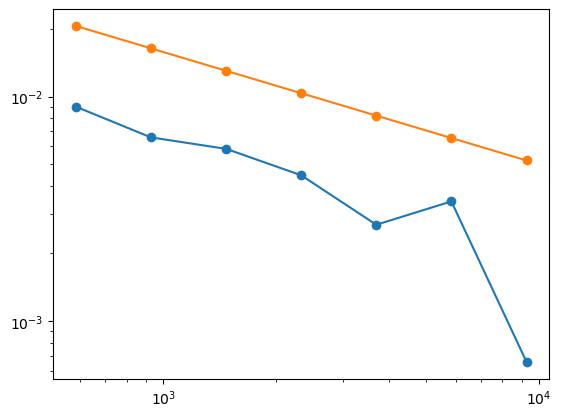

In [336]:
plt.loglog(difs_nums_Vs, difs_total_means, "o-")
plt.loglog(difs_nums_Vs, difs_nums_Vs**(-0.5) / 2, "o-")

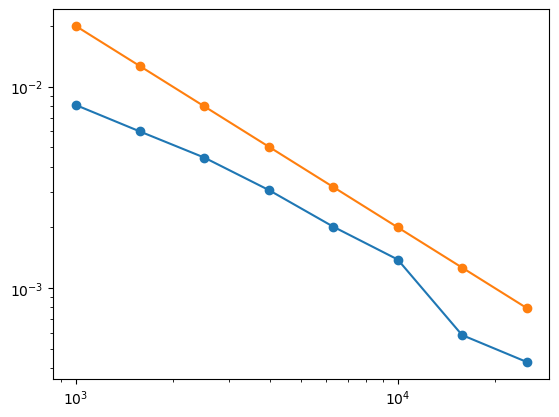

In [343]:
plt.loglog(list(eigenvalues.keys()), np.abs(total_means - continuum_eigenvalue) / continuum_eigenvalue, "o-")
plt.loglog(list(eigenvalues.keys()), np.array(list(eigenvalues.keys()))**(-1.) * 20, "o-")

# Calculations for coefficients

In [258]:
sphere_coefficient = 0.9202712102263128

0.9202712102263128

In [25]:
nums_Vs = (10**np.linspace(2, 5, 16)).astype(int)[5:13]
# nums_seeds = 5 * [128] + 3 * [64] + 3 * [32]

In [296]:
print(nums_Vs)

[ 1000  1584  2511  3981  6309 10000 15848 25118]


## Get coefficients by calculation or import

### Calculate coefficients

In [301]:
coefficients = {}

In [308]:
for en, num_Vs in enumerate(nums_Vs[2:]):

    en += 2

    print(f"\n\ngraph size = {en + 1} / {len(nums_Vs)}\n\n\n")

    coefficients[num_Vs] = []
    check = False
    seed = -1

    if en == 0:
        previous_mean = None
    else:
        previous_mean = np.mean(coefficients[nums_Vs[en - 1]])

    while not check:
        seed += 1
        np.random.seed(seed)
        rd = construct_graph.patch_graph.Random_Delaunay(num_Vs)
        g = construct_graph.patch_graph.Patch(rd)
        print(f"\nSEED = {seed}, num_Vs = {g.num_Vs}\n")
        eq = construct_graph.patch_graph.Cell_Problem(g)
        xi = eq.solve_corrector_equation()

        coefficients[num_Vs].append(eq.construct_homogenized_tensor(xi))

        check = check_convergence(coefficients[num_Vs], mean_previous_graph_size=previous_mean)



graph size = 3 / 8




SEED = 0, num_Vs = 2511


SEED = 1, num_Vs = 2511


SEED = 2, num_Vs = 2511


Current dif = 0.0011665818095082303 vs. adaptive tol = 3.734677511323567e-05


SEED = 3, num_Vs = 2511


Current dif = 6.963675838652248e-05 vs. adaptive tol = 3.8045743405455974e-05


SEED = 4, num_Vs = 2511


Current dif = 4.871354618146135e-05 vs. adaptive tol = 3.755675460056297e-05


SEED = 5, num_Vs = 2511


Current dif = 0.0005190915404020484 vs. adaptive tol = 3.234634380294438e-05


SEED = 6, num_Vs = 2511


Current dif = 3.656926954728276e-05 vs. adaptive tol = 3.2713219380582605e-05


SEED = 7, num_Vs = 2511


Current dif = 0.00024569453769208906 vs. adaptive tol = 3.517820221681563e-05


SEED = 8, num_Vs = 2511


Current dif = 0.00014409509839938492 vs. adaptive tol = 3.373218222631183e-05


SEED = 9, num_Vs = 2511


Current dif = 6.11030588155485e-05 vs. adaptive tol = 3.3119090498641796e-05


SEED = 10, num_Vs = 2511


Current dif = 0.00015452884701176703 vs. adaptive to

In [383]:
seed = 1
np.random.seed(seed)
rd = construct_graph.patch_graph.Random_Delaunay(80000)
g = construct_graph.patch_graph.Patch(rd)
print(f"\nSEED = {seed}, num_Vs = {g.num_Vs}\n")


SEED = 1, num_Vs = 80000



In [ ]:
eq = construct_graph.patch_graph.Cell_Problem(g)
xi = eq.solve_corrector_equation()

c = eq.construct_homogenized_tensor(xi)

print(c)

In [385]:
LHS, RHS = eq.construct_equation()

In [392]:
cholesky = sksparse.cholmod.cholesky(LHS + 1e-12 * scipy.sparse.identity(LHS.shape[0], format='csc'))
xi_cho = cholesky(RHS)
xi_cho = xi_cho.toarray()
c_cho = eq.construct_homogenized_tensor(xi_cho)
print(c_cho)

0.9191204677360838


In [393]:
np.linalg.norm(LHS @ xi_cho - RHS)

1.171778448398205e-10

In [388]:
print(c)

0.9191204677361071


In [ ]:
# For 50000: 0.9187205788357494

### Import coefficients

In [ ]:
# file = open("data/delaunay_coefficients.pkl", "wb")
# pickle.dump(coefficients, file)
# file.close()

# file = open("data/delaunay_coefficients.pkl", "rb")
# coefficients = pickle.load(file)
# file.close()

In [309]:
0.95925221**2

0.9201648023898842

## Plot results

In [312]:
coefficients_means = []
for num_Vs in nums_Vs:
    coefficients_means.append(np.mean(coefficients[num_Vs]))
coefficients_means = np.array(coefficients_means)

In [320]:
0.92**0.5

0.9591663046625439

In [505]:
print(coefficients_means)

[0.91027064 0.91225905 0.91322383 0.91497013 0.91602365 0.91727218
 0.91835739 0.91811106]


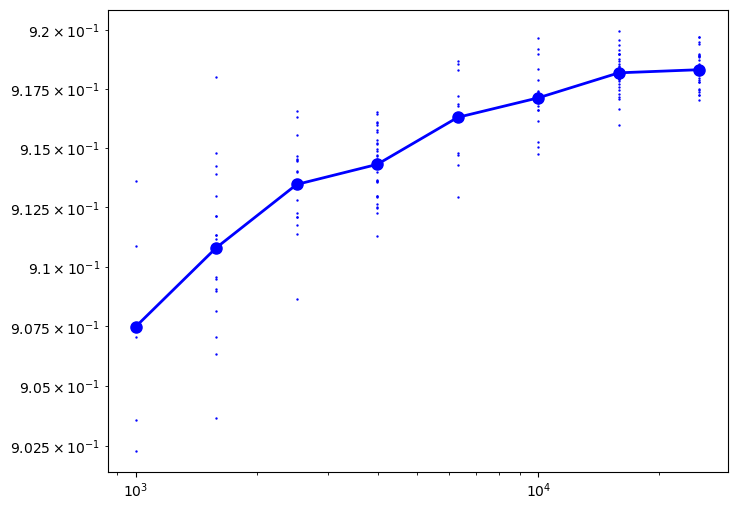

In [316]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.loglog(nums_Vs, coefficients_means, 'o-', markersize=8, c='b', linewidth=2)
for num_Vs in nums_Vs:
    x = num_Vs * np.ones(len(coefficients[num_Vs]))
    y = coefficients[num_Vs]
    ax.scatter(x, y, s=0.5, c='b')

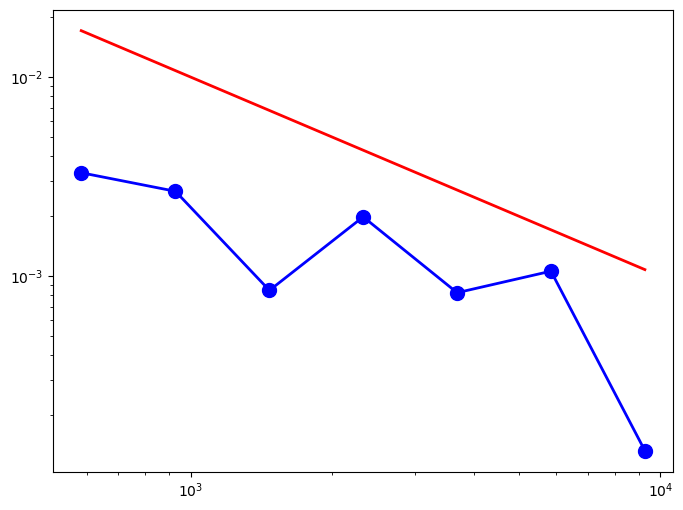

In [315]:
difs = [np.abs(coefficients_means[i] - coefficients_means[i + 1]) for i in range(len(coefficients_means) - 1)]
num_Vs_difs = [np.abs(nums_Vs[i] - nums_Vs[i + 1]) for i in range(len(coefficients_means) - 1)]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.loglog(num_Vs_difs, difs, 'o-', markersize=10, c='b', linewidth=2)
ax.loglog(num_Vs_difs, np.array(num_Vs_difs)**(-1.) * 10, markersize=10, c='r', linewidth=2)